In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from joblib import Parallel, delayed

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 18

%matplotlib inline

In [2]:
from doubleml.datasets import fetch_401K

In [3]:
# Make figures directory
if not os.path.exists("figures"):
    os.makedirs("figures")

# 401(k) Real-World Scenario

Reproduces Figures 2 and 3 from "Estimating Heterogeneous Treatment Effects by Combining Weak Instruments and Observational Data".

### 1. Preprocess data

In [4]:
df = fetch_401K(return_type='DataFrame')
df.head()

,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
0,0.0,0.0,4500.0,47,6765.0,2,8,0,0,0,0,0,0,1
1,6215.0,1015.0,22390.0,36,28452.0,1,16,0,0,0,0,0,0,1
2,0.0,-2000.0,-2000.0,37,3300.0,6,12,1,0,0,0,0,0,0
3,15000.0,15000.0,155000.0,58,52590.0,2,16,0,1,1,0,0,0,1
4,0.0,0.0,58000.0,32,21804.0,1,11,0,0,0,0,0,0,1


In [5]:
# Select features
# X1: age (int)
# X2: inc -> income (int)
# X3: educ -> education, in #years completed (int)
# X4: fsize -> family size (int)
# X5: marr -> marrital status (binary)
# X6: two_earn -> two earners (binary)
# X7: db -> defined benefit pension status (binary)
# X8: pira -> IRA participation (binary)
# X9: hown -> home ownership (binary)
# Z: p401 -> 401 (k) participation (binary)
# A: e401 -> 401 (k) eligibility (binary)
# Y: net_tfa -> net financial assets (float)
feat_names = ['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown']
# RF hyperparams
n_estimators = 100
max_depth = 6
max_features = 3
min_samples_leaf = 10

In [6]:
Y_raw = df["net_tfa"].values

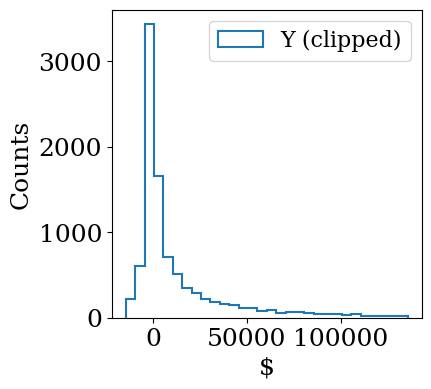

In [7]:
plt.figure(figsize=(4, 4))
plt.hist(Y_raw, bins=np.arange(np.percentile(Y_raw, 2.5), np.percentile(Y_raw, 97.5), 5000), histtype="step", label="Y (clipped)", zorder=5, color="C0", lw=1.5)
plt.legend(fontsize=16)
plt.ylabel("Counts")
plt.xlabel("$")
#plt.savefig("figures/401k_Y_dist.pdf", dpi=200, bbox_inches="tight")
plt.show()

In [8]:
# Remove outliers
outlier_filter = (Y_raw <= np.percentile(Y_raw, 97.5)) &  (Y_raw >= np.percentile(Y_raw, 2.5))
Y = Y_raw[outlier_filter]
X = df[feat_names].values[outlier_filter]
A = df["p401"].values[outlier_filter]
Z = df["e401"].values[outlier_filter]

In [9]:
# Scale data
X_means = []
X_std = []
for i in range(4):
    Xi_mean = X[:, i].mean()
    X_means.append(Xi_mean)
    Xi_std = X[:, i].std()
    X_std.append(Xi_std)
    X[:, i] = (X[:, i] - Xi_mean)/Xi_std
Y_mean = Y.mean()
Y_std = Y.std()
Y = (Y-Y_mean)/Y_std

In [10]:
# Split into 2 datasets, one "experimental" and one "observational"
X_O, X_E, Z_O, Z_E, A_O, A_E, Y_O, Y_E = train_test_split(X, Z, A, Y, test_size=0.5, random_state=1)

### 2. Learn $\widehat{\gamma}$, $\widehat{\pi}_Z$, $\widehat{\tau}^O$, $\widehat{\tau}^E$

In [11]:
np.random.seed(1)
### Get ground truth by getting CATEs on the IV dataset
# Get one-sided compliance score
pi1_z_model = RandomForestClassifier(
    n_estimators=n_estimators, max_depth=max_depth, 
    max_features=max_features, min_samples_leaf=5, n_jobs=-2)
pi1_z_model.fit(X_E[Z_E==1], A_E[Z_E==1])
# Get Z outcome models
mu1_z_model =  RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, 
    max_features=max_features, min_samples_leaf=min_samples_leaf, n_jobs=-2)
mu1_z_model.fit(X_E[Z_E==1], Y_E[Z_E==1])
mu0_z_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, 
    max_features=max_features, min_samples_leaf=min_samples_leaf, n_jobs=-2)
mu0_z_model.fit(X_E[Z_E==0], Y_E[Z_E==0])
# CATE model
cate_iv = lambda x: (mu1_z_model.predict(x) - mu0_z_model.predict(x)) / pi1_z_model.predict_proba(x)[:, 1]

In [12]:
### Get observational CATE
# Y models for observational data
mu1_a_model =  RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, 
    max_features=max_features, min_samples_leaf=min_samples_leaf, n_jobs=-2)
mu1_a_model.fit(X_O[A_O==1], Y_O[A_O==1])
mu0_a_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, 
    max_features=max_features, min_samples_leaf=min_samples_leaf, n_jobs=-2)
mu0_a_model.fit(X_O[A_O==0], Y_O[A_O==0])
# CATE model
cate_obs = lambda x: mu1_a_model.predict(x) - mu0_a_model.predict(x)

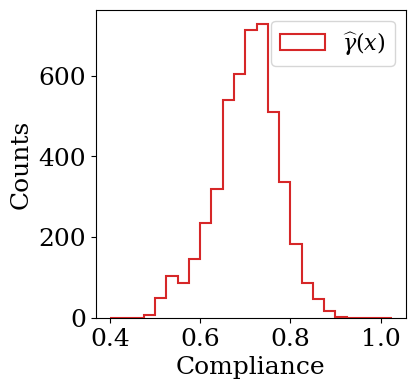

In [13]:
plt.figure(figsize=(4, 4))
plt.hist(pi1_z_model.predict_proba(X_E)[:, 1], bins=np.arange(0.4, 1.05, 0.025), histtype="step", label=r"$\widehat{\gamma}(x)$", zorder=5, color="C3", lw=1.5)
plt.legend(loc="upper right", fontsize=16)
plt.xlabel("Compliance")
plt.ylabel("Counts")
plt.savefig("figures/401k_compliance_dist.pdf", dpi=200, bbox_inches="tight")
plt.show()

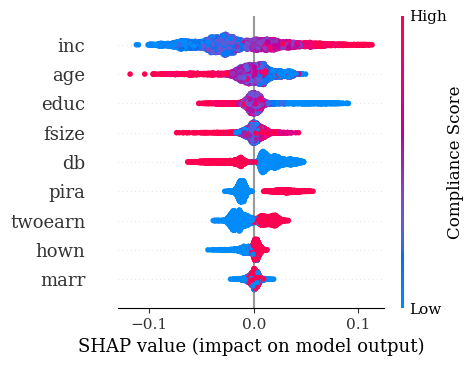

In [14]:
# SHAP plot for compliance
explainer = shap.TreeExplainer(pi1_z_model)
shap_values = explainer.shap_values(X_E)
feat_idx = np.argsort(pi1_z_model.feature_importances_)[::-1]
shap.summary_plot(shap_values[1][:, feat_idx], 
                  X_E[:, feat_idx], 
                  feature_names=np.array(feat_names)[feat_idx], 
                  sort=False, plot_size=(5,4), color_bar_label="Compliance Score", show=False)
fig = plt.gcf()
with plt.rc_context({'pdf.fonttype': 42, 'ps.fonttype':42, 'font.size':18, 'font.family': 'serif'}):
    fig.savefig("figures/401k_compliance_feats.pdf", dpi=200, bbox_inches="tight")
plt.show()

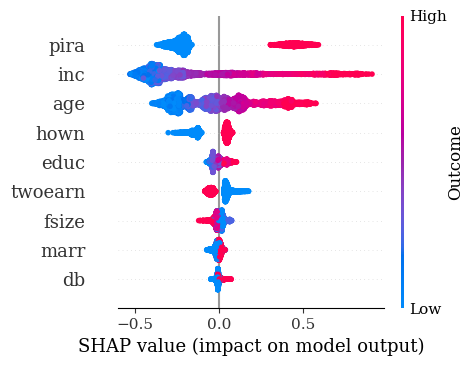

In [15]:
# SHAP plot for outcome models
explainer = shap.TreeExplainer(mu1_a_model)
shap_values = explainer.shap_values(X_E)
feat_idx = np.argsort(mu1_z_model.feature_importances_)[::-1]

shap.summary_plot(shap_values[:, feat_idx], 
                  X_E[:, feat_idx], 
                  feature_names=np.array(feat_names)[feat_idx], 
                  sort=False, plot_size=(5,4), color_bar_label="Outcome", show=False)
fig = plt.gcf()
with plt.rc_context({'pdf.fonttype': 42, 'ps.fonttype':42, 'font.size':18, 'font.family': 'serif'}):
    fig.savefig("figures/401k_outcome_a_1_feats.pdf", dpi=200, bbox_inches="tight")
plt.show()

In [16]:
# Learn pi_Z model
pi_z_model = RandomForestClassifier(
    n_estimators=n_estimators, max_depth=max_depth, 
    max_features=max_features, min_samples_leaf=5, n_jobs=-2)
pi_z_model.fit(X_E, Z_E)

RandomForestClassifier(max_depth=6, max_features=3, min_samples_leaf=5,
                       n_jobs=-2)

### 3. Apply Algorithm 1

In [17]:
# Test data with varying income and fixed everything else
#age_range = np.arange(25, 65)
#X_test = np.empty((age_range.size, 9))
edu_range = np.arange(8, 19)
X_test = np.empty((edu_range.size, 9))
#X_test[:, 0] = age_range
X_test[:, 0] = (40 - X_means[0])/X_std[0]
X_test[:, 1] = (30000 - X_means[1])/X_std[1]
X_test[:, 2] = (edu_range - X_means[2])/X_std[2]
X_test[:, 3] = (1-X_means[3])/X_std[3]
X_test[:, 4] = 0
X_test[:, 5] = 0
X_test[:, 6] = 0
X_test[:, 7] = 0
X_test[:, 8] = 0

In [18]:
bias_model = Pipeline([
    ('polynomial_features', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),  # Polynomial transformation with degree 2
    ('standard_scaler', StandardScaler()),
    ('regressor', Lasso(alpha=0.07))  # Example regressor
])
gamma = pi1_z_model.predict_proba(X_E)[:, 1]
pi_z = pi_z_model.predict_proba(X_E)[:, 1]
V_z = pi_z*(1-pi_z)
weights = (gamma**2)*V_z
Y_tilde = (Y_E*Z_E/pi_z - Y_E*(1-Z_E)/(1-pi_z))/gamma - cate_obs(X_E)
compliance_filter = (X_E[:, 2]>=(12 - X_means[2])/X_std[2])
bias_model.fit(X_E[compliance_filter], Y_tilde[compliance_filter], regressor__sample_weight=weights[compliance_filter])

Pipeline(steps=[('polynomial_features',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('standard_scaler', StandardScaler()),
                ('regressor', Lasso(alpha=0.07))])

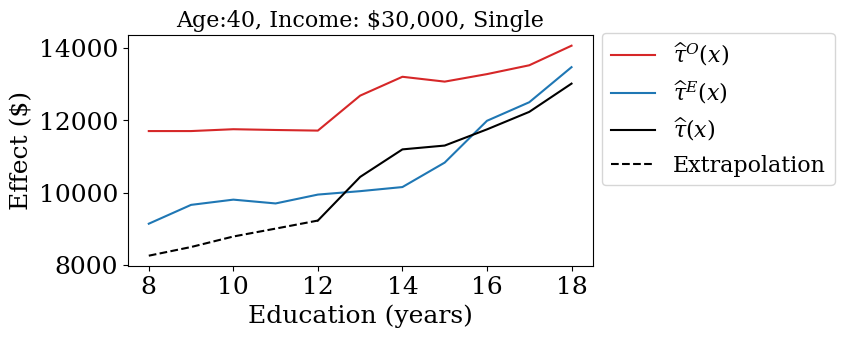

In [19]:
plt.figure(figsize=(6, 3))
plt.plot(edu_range, cate_obs(X_test)*Y_std, label=r"$\widehat{\tau}^O(x)$", color="C3")
plt.plot(edu_range, cate_iv(X_test)*Y_std, label=r"$\widehat{\tau}^E(x)$")
plt.plot(edu_range[edu_range>=12], (cate_obs(X_test)*Y_std + bias_model.predict(X_test)*Y_std)[edu_range>=12], label=r"$\widehat{\tau}(x)$", color="black")
plt.plot(edu_range[edu_range<=12], (cate_obs(X_test)*Y_std + bias_model.predict(X_test)*Y_std)[edu_range<=12], label="Extrapolation", color="black", ls='--')
plt.legend(loc=(1.02, 0.35), fontsize=16)
plt.xlabel("Education (years)")
plt.ylabel("Effect ($)")
plt.title("Age:40, Income: $30,000, Single", fontsize=16)
plt.savefig("figures/401k_parametric_extrapolation_single.pdf", dpi=200, bbox_inches="tight")
plt.show()

In [20]:
# Change marital status (and household size)
X_test[:, 3] = (2-X_means[3])/X_std[3]
X_test[:, 4] = 1

bias_model = Pipeline([
    ('polynomial_features', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),  # Polynomial transformation with degree 2
    ('standard_scaler', StandardScaler()),
    ('regressor', Lasso(alpha=0.07))  # Example regressor
])
gamma = pi1_z_model.predict_proba(X_E)[:, 1]
pi_z = pi_z_model.predict_proba(X_E)[:, 1]
V_z = pi_z*(1-pi_z)
weights = (gamma**2)*V_z
Y_tilde = (Y_E*Z_E/pi_z - Y_E*(1-Z_E)/(1-pi_z))/gamma - cate_obs(X_E)
compliance_filter = (X_E[:, 2]>=(12 - X_means[2])/X_std[2])
bias_model.fit(X_E[compliance_filter], Y_tilde[compliance_filter], regressor__sample_weight=weights[compliance_filter])

Pipeline(steps=[('polynomial_features',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('standard_scaler', StandardScaler()),
                ('regressor', Lasso(alpha=0.07))])

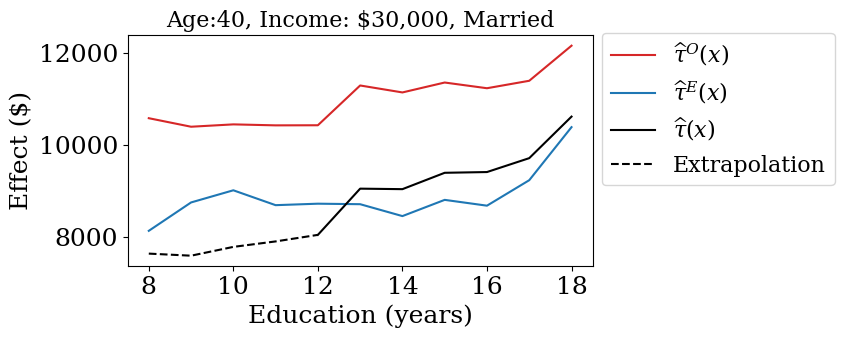

In [21]:
plt.figure(figsize=(6, 3))
plt.plot(edu_range, cate_obs(X_test)*Y_std, label=r"$\widehat{\tau}^O(x)$", color="C3")
plt.plot(edu_range, cate_iv(X_test)*Y_std, label=r"$\widehat{\tau}^E(x)$")
plt.plot(edu_range[edu_range>=12], (cate_obs(X_test)*Y_std + bias_model.predict(X_test)*Y_std)[edu_range>=12], label=r"$\widehat{\tau}(x)$", color="black")
plt.plot(edu_range[edu_range<=12], (cate_obs(X_test)*Y_std + bias_model.predict(X_test)*Y_std)[edu_range<=12], label="Extrapolation", color="black", ls='--')
plt.legend(loc=(1.02, 0.35), fontsize=16)
plt.xlabel("Education (years)")
plt.ylabel("Effect ($)")
plt.title("Age:40, Income: $30,000, Married", fontsize=16)
plt.savefig("figures/401k_parametric_extrapolation_married.pdf", dpi=200, bbox_inches="tight")
plt.show()